<a href="https://colab.research.google.com/github/R1sh11172/Bone-Break-Classification/blob/main/BoneBreakClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bone Break Computer Vision Model

Convolutional Neural Network developed using EfficientNet_B2 and VisionTransformer models

#### Resources
*   https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html



## Dataset Setup and Preprocessing

In [ ]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.1.2+cu121
torchvision version: 0.16.2+cu121


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (4056/4056), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 4056 (delta 2387), reused 3946 (delta 2369), pack-reused 0
Receiving objects: 100% (4056/4056), 649.87 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
dataset = download_data(source="https://github.com/R1sh11172/Bone-Break-Classification/raw/main/bone_break_classification.zip",
                                     destination="data")

dataset


[INFO] Did not find data/data directory, creating one...
[INFO] Downloading bone_break_classification.zip from https://github.com/R1sh11172/Bone-Break-Classification/raw/main/bone_break_classification.zip...
[INFO] Unzipping bone_break_classification.zip data...


PosixPath('data/data')

In [ ]:
train_dir = dataset / "bone_break_classification" / "train"
test_dir = dataset / "bone_break_classification" / "test"

## Model Development


In [ ]:
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url
# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict


effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
    param.requires_grad = False

effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=10))

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 145MB/s]


In [ ]:
def create_effnetb2_model(num_classes:int=10, seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [ ]:
from torchinfo import summary
# summary(effnetb2, input_size=(1, 3, 224, 224),
#       col_names=["input_size", "output_size", "num_params", "trainable"],
#       col_width=20,
#       row_settings=["var_names"])

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
# optimizer = torch.optim.Adam(params=effnetb2.parameters(),
#                              lr=1e-3)

optimizer = torch.optim.SGD(params=effnetb2.parameters(), lr=0.1)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2254 | train_acc: 0.1973 | test_loss: 2.2202 | test_acc: 0.1562
Epoch: 2 | train_loss: 1.9815 | train_acc: 0.3188 | test_loss: 2.2196 | test_acc: 0.1938
Epoch: 3 | train_loss: 1.8277 | train_acc: 0.3748 | test_loss: 2.1158 | test_acc: 0.2542
Epoch: 4 | train_loss: 1.6838 | train_acc: 0.4457 | test_loss: 2.1874 | test_acc: 0.1875
Epoch: 5 | train_loss: 1.6138 | train_acc: 0.4696 | test_loss: 2.1054 | test_acc: 0.2729
Epoch: 6 | train_loss: 1.5834 | train_acc: 0.4830 | test_loss: 2.1336 | test_acc: 0.2292
Epoch: 7 | train_loss: 1.5039 | train_acc: 0.5104 | test_loss: 2.1227 | test_acc: 0.2479
Epoch: 8 | train_loss: 1.4572 | train_acc: 0.5401 | test_loss: 2.1390 | test_acc: 0.2396
Epoch: 9 | train_loss: 1.4275 | train_acc: 0.5316 | test_loss: 2.1112 | test_acc: 0.2479
Epoch: 10 | train_loss: 1.3789 | train_acc: 0.5569 | test_loss: 2.2083 | test_acc: 0.2000


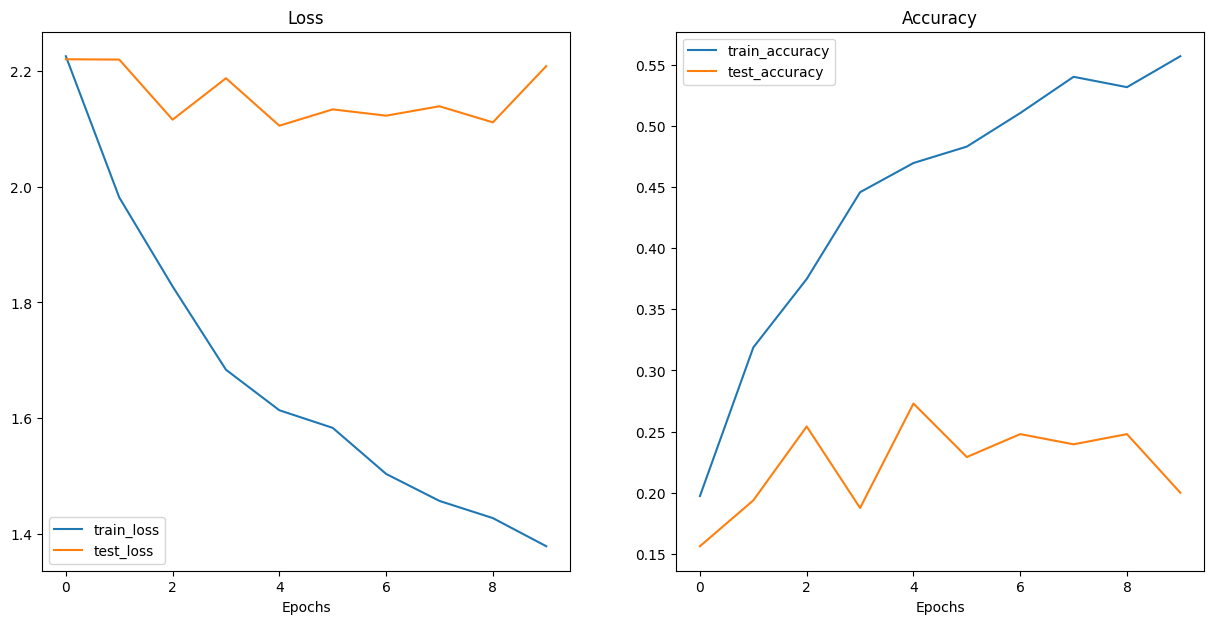

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_bone_break_dataset.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_bone_break_dataset.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_bone_break_dataset.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")


Pretrained EffNetB2 feature extractor model size: 29 MB


In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7715084

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 2.2083376169204714,
 'test_acc': 0.2,
 'number_of_parameters': 7715084,
 'model_size (MB)': 29}

In [ ]:
# Check out ViT heads layer
vit = torchvision.models.vit_l_32()
vit.heads

Sequential(
  (head): Linear(in_features=1024, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=10,
                     seed:int=42):

    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_L_32_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_l_32(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=1024, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=10,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_l_32-c7638314.pth" to /root/.cache/torch/hub/checkpoints/vit_l_32-c7638314.pth
100%|██████████| 1.14G/1.14G [01:26<00:00, 14.1MB/s]


In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# optimizer = torch.optim.SGD(params=effnetb2.parameters(), lr=0.1)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=15,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.5921 | train_acc: 0.8008 | test_loss: 16.3261 | test_acc: 0.3896
Epoch: 2 | train_loss: 3.7987 | train_acc: 0.8626 | test_loss: 15.5011 | test_acc: 0.4313
Epoch: 3 | train_loss: 3.4933 | train_acc: 0.9083 | test_loss: 15.1429 | test_acc: 0.4313
Epoch: 4 | train_loss: 3.3408 | train_acc: 0.9343 | test_loss: 14.9497 | test_acc: 0.4313
Epoch: 5 | train_loss: 3.2328 | train_acc: 0.9434 | test_loss: 14.7964 | test_acc: 0.4313
Epoch: 6 | train_loss: 3.1530 | train_acc: 0.9576 | test_loss: 14.6304 | test_acc: 0.4250
Epoch: 7 | train_loss: 3.0896 | train_acc: 0.9627 | test_loss: 14.5073 | test_acc: 0.4313
Epoch: 8 | train_loss: 3.0359 | train_acc: 0.9708 | test_loss: 14.4065 | test_acc: 0.4313
Epoch: 9 | train_loss: 2.9900 | train_acc: 0.9778 | test_loss: 14.2783 | test_acc: 0.4083
Epoch: 10 | train_loss: 2.9509 | train_acc: 0.9798 | test_loss: 14.1749 | test_acc: 0.4021
Epoch: 11 | train_loss: 2.9153 | train_acc: 0.9838 | test_loss: 14.0809 | test_acc: 0.3896
Epoch: 1

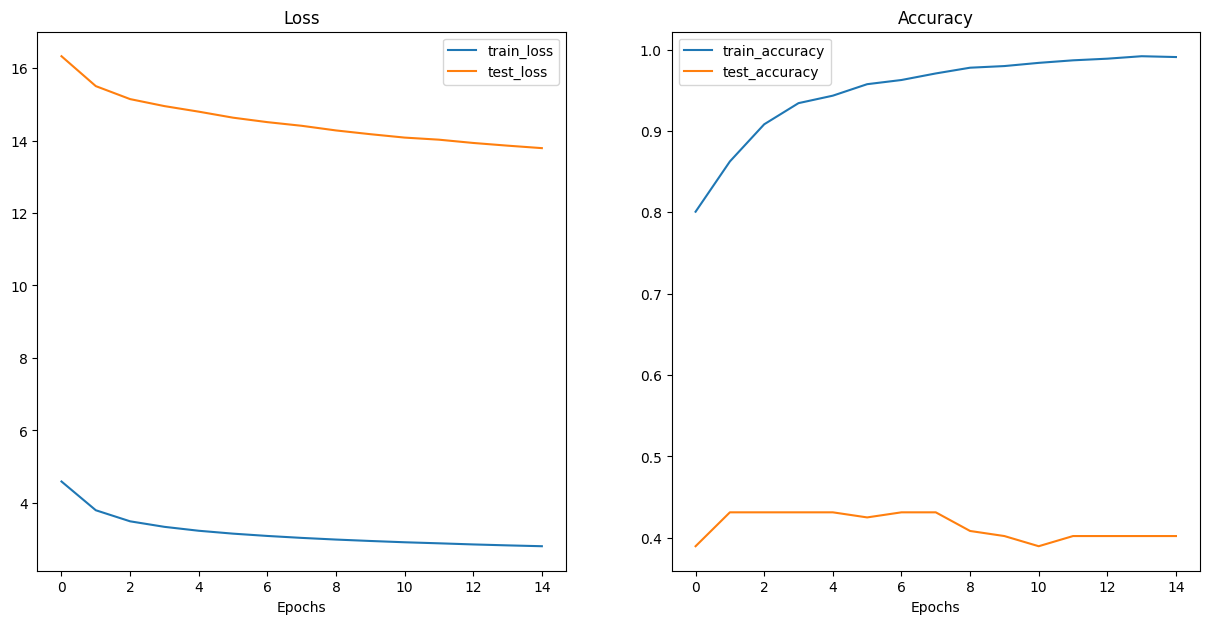

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_bone_break_dataset.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_bone_break_dataset.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_bone_break_dataset.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 1165 MB


In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

305520650

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 2.061475086212158,
 'test_acc': 0.4208333333333333,
 'number_of_parameters': 305520650,
 'model_size (MB)': 1165}

In [ ]:
finalModel = torchvision.models.vgg19_bn()

In [ ]:
from pathlib import Path

print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/data/bone_break_classification/test


[PosixPath('data/data/bone_break_classification/test/greenstick/27947ea707d39e57b0c14db8fc93d3_jumbo_jpeg.rf.d7f9014c5a33717ff2b8f7213e38524b.jpg'),
 PosixPath('data/data/bone_break_classification/test/greenstick/001_jumbo_jpeg.rf.ebf440662388fc36df361ce39890acb2.jpg'),
 PosixPath('data/data/bone_break_classification/test/greenstick/7410b6b41bc4e99e1f93bab41283b1_jumbo_jpg.rf.72d8073f7a1382ca542077a8487a5a37.jpg'),
 PosixPath('data/data/bone_break_classification/test/greenstick/15ff6b9162cf7c04caad3fbd4f4a2e_gallery_jpg.rf.bdcd5db0dd212b125b361a70ddf63265.jpg'),
 PosixPath('data/data/bone_break_classification/test/greenstick/2560px-Greenstick_fracture2C_A-P_view_jpg.rf.290485498308a848fd2518e20b0426b1.jpg')]

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/140 [00:00<?, ?it/s]

In [ ]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/data/bone_break_classification/test/greenstick/27947ea707d39e57b0c14db8fc93d3_jumbo_jpeg.rf.d7f9014c5a33717ff2b8f7213e38524b.jpg'),
  'class_name': 'greenstick',
  'pred_prob': 1.0,
  'pred_class': 'greenstick',
  'time_for_pred': 0.644,
  'correct': True},
 {'image_path': PosixPath('data/data/bone_break_classification/test/greenstick/001_jumbo_jpeg.rf.ebf440662388fc36df361ce39890acb2.jpg'),
  'class_name': 'greenstick',
  'pred_prob': 0.6486,
  'pred_class': 'dislocation',
  'time_for_pred': 0.6504,
  'correct': False}]

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/data/bone_break_classification/test/green...,greenstick,1.0000,greenstick,0.6440,True
1,data/data/bone_break_classification/test/green...,greenstick,0.6486,dislocation,0.6504,False
2,data/data/bone_break_classification/test/green...,greenstick,0.9760,dislocation,0.6508,False
3,data/data/bone_break_classification/test/green...,greenstick,0.9217,dislocation,0.6483,False
4,data/data/bone_break_classification/test/green...,greenstick,1.0000,greenstick,0.6817,True


In [ ]:
vit_test_pred_df.correct.value_counts()

False    84
True     56
Name: correct, dtype: int64

In [ ]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),model
0,2.208338,20.00,7715084,29,EffNetB2
1,2.061475,42.08,305520650,1165,ViT


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("Bone Break Classification Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("images/09-bone-break-classification-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

User Interface

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

In [ ]:
# Put EffNetB2 on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "Bone Break Classifier"
description = "An EfficientNetB2 feature extractor computer vision model to identify 10 different types of fractures."
article = "Created by Rishi Aniga"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

In [ ]:
import shutil
from pathlib import Path

bone_break_classifier_demo_path = Path("demos/bone_break_classifier/")

# Remove files that might already exist there and create new directory
if bone_break_classifier_demo_path.exists():
    shutil.rmtree(bone_break_classifier_demo_path)
    bone_break_classifier_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    bone_break_classifier_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check what's in the folder
!ls demos/bone_break_classifier_demo_path/

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
bone_break_classifier_demo_path = bone_break_classifier_demo_path / "examples"
bone_break_classifier_demo_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
bone_break_classification_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in bone_break_classification_examples:
    destination = bone_break_classification_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(bone_break_classification_examples_path)]
example_list

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_bone_break_classification_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_bone_break_classification_model_destination = bone_break_classification_demo_path / effnetb2_bone_break_classification_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_bone_break_classification_model_path} to {effnetb2_bone_break_classification_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_bone_break_classification_model_path,
                dst=effnetb2_bone_break_classification_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_bone_break_classification_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_bone_break_classification_model_destination}: {effnetb2_bone_break_classification_model_destination.exists()}")